# SVM With HNM
The hyperparameters cell contains a variable for input and output paths which the user must specify. 

In [1]:
!pip install pandas matplotlib seaborn pyyaml opencv-python tqdm numpy scikit-learn scikit-image
!sudo apt-get update && sudo apt-get install -y libgl1-mesa-glx

Defaulting to user installation because normal site-packages is not writeable
Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.1 kB]
Hit:3 http://deb.debian.org/debian bullseye-updates InRelease
Get:4 https://dl.yarnpkg.com/debian stable InRelease
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [423 kB]
Fetched 467 kB in 1s (539 kB/s)   
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.3.5-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [ ]:
import gc
import glob
import os
import random
import time
from collections import Counter
import joblib
import yaml
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)

In [3]:
# Directory which contains the folder "archive" containing ["test", "train", "valid", "data.yaml"]
INPUT_DRIVE_PATH = "/workspaces/comp9517/project" 
# Directory where outputs will be saved and cached
OUTPUT_DRIVE_PATH = "/mnt/d/COMP9517 Data"

### HYPERPARAMETERS

# Data
DATA_SUBSET_PROPORTION = 1.0 # Percentage of the dataset to use
PATCH_SIZE = (64, 64)
NUM_CHUNKS = 5 # Split the data and train from disk (to reduce RAM usage)

# Training
N_EPOCHS = 20
BATCH_SIZE = 4096

# HOG
USE_COLOR_HOG = True 
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (6, 6)
HOG_CELLS_PER_BLOCK = (2, 2)

# Detection
PYRAMID_SCALE = 1.5
STEP_SIZE = 12
NMS_THRESHOLD = 0.3 # IoU threshold for non-max suppression
IOU_THRESHOLD = 0.5 # IoU threshold for a "correct" match in evaluation

# Hard Negative Mining
HNM_SUBSET_PROPORTION = 1.0 # Percent of training images for mining
FP_IOU_THRESHOLD = 0.1 # IoU threshold to consider a detection a false positive
HNM_NUM_CHUNKS = 20 # Split HNM process into this many chunks for resumability

# Evaluation
EVAL_SUBSET_PERCENT = 1.0 # Use 10% of test set for final evaluation
VIZ_PER_PIPELINE = 2 # Number of images to visualize for each pipeline

In [4]:
os.makedirs(OUTPUT_DRIVE_PATH, exist_ok=True)

### CONFIG

BASE_PATH = os.path.join(INPUT_DRIVE_PATH, "archive")
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train", "images")
TRAIN_LABEL_DIR = os.path.join(BASE_PATH, "train", "labels")
VALID_IMG_DIR = os.path.join(BASE_PATH, "valid", "images")
VALID_LABEL_DIR = os.path.join(BASE_PATH, "valid", "labels")
TEST_IMG_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_LABEL_DIR = os.path.join(BASE_PATH, "test", "labels")
YAML_PATH = os.path.join(BASE_PATH, "data.yaml")

HNM_CHUNKS_DIR = os.path.join(OUTPUT_DRIVE_PATH, "hnm_chunks") 
FEATURE_TYPE_PREFIX = "color_hog" if USE_COLOR_HOG else "gray_hog"
MODEL_FILE = os.path.join(OUTPUT_DRIVE_PATH, f"svm_model_{FEATURE_TYPE_PREFIX}.joblib")
SCALER_FILE = os.path.join(OUTPUT_DRIVE_PATH, f"scaler_{FEATURE_TYPE_PREFIX}.joblib")
MODEL_FILE_V2 = os.path.join(OUTPUT_DRIVE_PATH, f"svm_model_{FEATURE_TYPE_PREFIX}_v2.joblib")
SCALER_FILE_V2 = os.path.join(OUTPUT_DRIVE_PATH, f"scaler_{FEATURE_TYPE_PREFIX}_v2.joblib")

with open(YAML_PATH, "r") as file:
    data_config = yaml.safe_load(file)
class_names = data_config["names"]

def get_hog_feature_size(patch_size, orientations, ppc, cpb, use_color):
    """Calculates the HOG feature vector length based on HOG parameters."""
    dummy_patch = np.zeros((patch_size[1], patch_size[0]))
    fd = hog(dummy_patch, orientations=orientations, pixels_per_cell=ppc, cells_per_block=cpb, visualize=False)
    base_size = fd.shape[0]
    return base_size * 3 if use_color else base_size

HOG_FEATURE_SIZE = get_hog_feature_size(PATCH_SIZE, HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK, USE_COLOR_HOG)

def get_hog_features_for_patch(patch):
    """Extracts HOG features from a single, pre-resized patch."""
    if USE_COLOR_HOG:
        features = []
        for channel in range(patch.shape[2]): # Loop over B, G, R
            fd = hog(patch[:, :, channel],
                     orientations=HOG_ORIENTATIONS,
                     pixels_per_cell=HOG_PIXELS_PER_CELL,
                     cells_per_block=HOG_CELLS_PER_BLOCK,
                     visualize=False, channel_axis=None)
            features.append(fd)
        return np.concatenate(features)
    else:
        gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        return hog(gray_patch,
                     orientations=HOG_ORIENTATIONS,
                     pixels_per_cell=HOG_PIXELS_PER_CELL,
                     cells_per_block=HOG_CELLS_PER_BLOCK,
                     visualize=False)

def generate_hog_in_chunks(img_dir, lbl_dir, file_prefix="X_train"):
    """Generates HOG features and labels from images and saves them to disk in chunks."""
    all_img_files = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]
    
    if DATA_SUBSET_PROPORTION < 1.0:
        np.random.shuffle(all_img_files) # Only shuffle if we're subsetting
        
    num_files_to_use = int(len(all_img_files) * DATA_SUBSET_PROPORTION)
    img_files_to_process = all_img_files[:num_files_to_use]

    file_chunks = np.array_split(img_files_to_process, NUM_CHUNKS)

    for chunk_idx, file_chunk in enumerate(file_chunks):
        print(f"Processing chunk {chunk_idx + 1}/{NUM_CHUNKS}.")
        hog_features_chunk = []
        image_labels_chunk = []

        for img_name in tqdm(file_chunk):
            image_path = os.path.join(img_dir, img_name)
            image = cv2.imread(image_path)
            if image is None: continue
            img_h, img_w, _ = image.shape
            gt_boxes = []

            # Positive Patches
            label_path = os.path.join(lbl_dir, os.path.splitext(img_name)[0] + ".txt")
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f.readlines():
                        parts = line.strip().split(" ")
                        if len(parts) == 5:
                            class_id = int(parts[0])
                            x_c_norm, y_c_norm = float(parts[1]), float(parts[2])
                            w_norm, h_norm = float(parts[3]), float(parts[4])
                            box_w, box_h = int(w_norm * img_w), int(h_norm * img_h)
                            x_center, y_center = int(x_c_norm * img_w), int(y_c_norm * img_h)
                            x1, y1 = int(x_center - (box_w / 2)), int(y_center - (box_h / 2))
                            x2, y2 = int(x_center + (box_w / 2)), int(y_center + (box_h / 2))
                            gt_boxes.append((x1, y1, x2, y2))
                            patch = image[y1:y2, x1:x2]
                            if patch.size == 0: continue

                            resized_patch = cv2.resize(patch, PATCH_SIZE)

                            final_features = get_hog_features_for_patch(resized_patch)
                            if final_features is not None:
                                hog_features_chunk.append(final_features)
                                image_labels_chunk.append(class_id + 1)

            # Negative Patches (one attempt per image)
            if img_w > PATCH_SIZE[0] and img_h > PATCH_SIZE[1]:
                rand_x1 = np.random.randint(0, img_w - PATCH_SIZE[0])
                rand_y1 = np.random.randint(0, img_h - PATCH_SIZE[1])
                rand_x2 = rand_x1 + PATCH_SIZE[0]
                rand_y2 = rand_y1 + PATCH_SIZE[1]
                has_overlap = False
                for (gt_x1, gt_y1, gt_x2, gt_y2) in gt_boxes:
                    if (rand_x1 < gt_x2 and rand_x2 > gt_x1 and
                        rand_y1 < gt_y2 and rand_y2 > gt_y1):
                        has_overlap = True; break
    
                if not has_overlap:
                    patch = image[rand_y1:rand_y2, rand_x1:rand_x2]
                    resized_patch = cv2.resize(patch, PATCH_SIZE)
                    
                    final_features = get_hog_features_for_patch(resized_patch)
                    if final_features is not None:
                        hog_features_chunk.append(final_features)
                        image_labels_chunk.append(0)

        if len(hog_features_chunk) > 0:
            print(f"Chunk {chunk_idx + 1} saving. {len(hog_features_chunk)} samples.")
            # Save to the output drive
            features_path = os.path.join(OUTPUT_DRIVE_PATH, f"{file_prefix}_{FEATURE_TYPE_PREFIX}_chunk_{chunk_idx}.npy")
            labels_path = os.path.join(OUTPUT_DRIVE_PATH, f"{file_prefix}_{FEATURE_TYPE_PREFIX}_labels_chunk_{chunk_idx}.npy")
            np.save(features_path, np.array(hog_features_chunk))
            np.save(labels_path, np.array(image_labels_chunk))

        del hog_features_chunk, image_labels_chunk
        gc.collect()

    print(f"Chunk generation complete for {file_prefix}.")

In [5]:
print("Generating HOG features and labels.")
generate_hog_in_chunks(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, file_prefix="X_train")
generate_hog_in_chunks(TEST_IMG_DIR, TEST_LABEL_DIR, file_prefix="X_test")
generate_hog_in_chunks(VALID_IMG_DIR, VALID_LABEL_DIR, file_prefix="X_valid")
print("All data generated and saved to disk.")

print("Calculating class weights from y_train chunks.")
all_y_train = []
total_samples = 0
for i in range(NUM_CHUNKS):
    labels_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_train_{FEATURE_TYPE_PREFIX}_labels_chunk_{i}.npy")
    labels = np.load(labels_path, mmap_mode="r")
    all_y_train.append(labels)
    total_samples += len(labels)

y_train_full = np.concatenate(all_y_train)
all_classes = np.unique(y_train_full)
class_weight_dict = dict(zip(all_classes, compute_class_weight("balanced", classes=all_classes, y=y_train_full)))
del all_y_train, y_train_full
gc.collect()
print(f"Class weights calculated from {total_samples} total training samples.")

# Fit scaler
print(f"Fitting StandardScaler on all training chunks.")
scaler = StandardScaler()
for i in tqdm(range(NUM_CHUNKS)):
    chunk_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_train_{FEATURE_TYPE_PREFIX}_chunk_{i}.npy")
    X_chunk = np.load(chunk_path, mmap_mode="r")
    scaler.partial_fit(X_chunk)
    del X_chunk
    gc.collect()
print("Scaler fitted on all data.")

# Define model
model = SGDClassifier(loss="hinge", random_state=42,
                      class_weight=class_weight_dict, verbose=0,
                      max_iter=1000, tol=1e-3)

# Train model
print(f"Training with SGD for {N_EPOCHS} epochs.")
for epoch in range(N_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{N_EPOCHS}")
    chunk_order = np.random.permutation(NUM_CHUNKS)

    for chunk_idx in chunk_order:
        X_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_train_{FEATURE_TYPE_PREFIX}_chunk_{chunk_idx}.npy")
        y_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_train_{FEATURE_TYPE_PREFIX}_labels_chunk_{chunk_idx}.npy")
        X_chunk = np.load(X_path, mmap_mode="r")
        y_chunk = np.load(y_path, mmap_mode="r")
        
        print(f" Training on chunk {chunk_idx} ({len(y_chunk)} samples)")

        indices = np.random.permutation(len(y_chunk))
        n_batches = int(np.ceil(len(y_chunk) / BATCH_SIZE))

        for i in tqdm(range(n_batches)):
            batch_indices = indices[i*BATCH_SIZE : (i+1)*BATCH_SIZE]
            X_batch = X_chunk[batch_indices]
            y_batch = y_chunk[batch_indices]

            X_batch_scaled = scaler.transform(X_batch)
            model.partial_fit(X_batch_scaled, y_batch, classes=all_classes)

        del X_chunk, y_chunk
        gc.collect()

print("\nTraining complete.")

print(f"Saving fitted scaler and model to disk as {SCALER_FILE} and {MODEL_FILE}.")
joblib.dump(scaler, SCALER_FILE)
joblib.dump(model, MODEL_FILE)
print("Model and scaler saved.")

# We evaluate the classifier for development purposes to help find optimal hyperparameters.
print(f"\nClassifier Evaluation ({FEATURE_TYPE_PREFIX})")
print("Evaluating model on validation set.")
y_pred_full = []
y_valid_full = []

for i in range(NUM_CHUNKS):
    X_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_valid_{FEATURE_TYPE_PREFIX}_chunk_{i}.npy")
    y_path = os.path.join(OUTPUT_DRIVE_PATH, f"X_valid_{FEATURE_TYPE_PREFIX}_labels_chunk_{i}.npy")
    X_valid_chunk = np.load(X_path, mmap_mode="r")
    y_valid_chunk = np.load(y_path, mmap_mode="r")

    X_valid_scaled = scaler.transform(X_valid_chunk)
    y_pred_chunk = model.predict(X_valid_scaled)

    y_pred_full.append(y_pred_chunk)
    y_valid_full.append(y_valid_chunk)

    del X_valid_chunk, y_valid_chunk, X_valid_scaled, y_pred_chunk
    gc.collect()

print("Concatenating results.")
y_pred = np.concatenate(y_pred_full)
y_valid = np.concatenate(y_valid_full)

accuracy = accuracy_score(y_valid, y_pred)
print(f"\nValidation set classification accuracy: {accuracy * 100:.2f}%")

report_class_names = ["Background"] + class_names
unique_labels = np.unique(np.concatenate((y_valid, y_pred))).astype(int)
target_names = [report_class_names[i] for i in unique_labels]

print("\nClassification report:")
print(classification_report(y_valid, y_pred, labels=unique_labels, target_names=target_names, digits=3))

del y_pred, y_valid, y_pred_full, y_valid_full
gc.collect()

print("\nML model workflow complete.")

Generating HOG features and labels.
Processing chunk 1/5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [00:32<00:00, 71.59it/s]


Chunk 1 saving. 4011 samples.
Processing chunk 2/5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [00:30<00:00, 76.52it/s]


Chunk 2 saving. 3961 samples.
Processing chunk 3/5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2300/2300 [00:30<00:00, 76.63it/s]


Chunk 3 saving. 3915 samples.
Processing chunk 4/5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2300/2300 [00:29<00:00, 77.80it/s]


Chunk 4 saving. 3896 samples.
Processing chunk 5/5.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2300/2300 [00:28<00:00, 79.70it/s]


Chunk 5 saving. 3739 samples.
Chunk generation complete for X_train.
Processing chunk 1/5.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 95.95it/s]


Chunk 1 saving. 201 samples.
Processing chunk 2/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:01<00:00, 100.42it/s]


Chunk 2 saving. 184 samples.
Processing chunk 3/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:01<00:00, 100.10it/s]


Chunk 3 saving. 188 samples.
Processing chunk 4/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:01<00:00, 101.90it/s]


Chunk 4 saving. 184 samples.
Processing chunk 5/5.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:03<00:00, 35.19it/s]


Chunk 5 saving. 167 samples.
Chunk generation complete for X_test.
Processing chunk 1/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 100.46it/s]


Chunk 1 saving. 345 samples.
Processing chunk 2/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 102.78it/s]


Chunk 2 saving. 350 samples.
Processing chunk 3/5.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 93.92it/s]


Chunk 3 saving. 391 samples.
Processing chunk 4/5.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 88.51it/s]


Chunk 4 saving. 368 samples.
Processing chunk 5/5.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 219/219 [00:02<00:00, 104.08it/s]


Chunk 5 saving. 342 samples.
Chunk generation complete for X_valid.
All data generated and saved to disk.
Calculating class weights from y_train chunks.
Class weights calculated from 19522 total training samples.
Fitting StandardScaler on all training chunks.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.43s/it]


Scaler fitted on all data.
Training with SGD for 20 epochs.

Epoch 1/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.33s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.73s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.37s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.47s/it]



Epoch 2/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.12s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.08s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.60s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.21s/it]



Epoch 3/20
 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.11s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.32s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.08s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.04s/it]



Epoch 4/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.99s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.17s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.99s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.88s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.28s/it]



Epoch 5/20
 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.40s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.80s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.09s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.69s/it]



Epoch 6/20
 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.85s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.88s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.47s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.72s/it]



Epoch 7/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.36s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.58s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.33s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.23s/it]



Epoch 8/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.52s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.54s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.01s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.03s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]



Epoch 9/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.21s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.81s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.96s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.62s/it]



Epoch 10/20
 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.80s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.89s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.81s/it]



Epoch 11/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.57s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.65s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.55s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.68s/it]



Epoch 12/20
 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.22s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.68s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.34s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.89s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.77s/it]



Epoch 13/20
 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.35s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.69s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.70s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.60s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.50s/it]



Epoch 14/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.86s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.62s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]



Epoch 15/20
 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.72s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.15s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.57s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.75s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.89s/it]



Epoch 16/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.21s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.83s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.27s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.00s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.40s/it]



Epoch 17/20
 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.83s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.31s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.89s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.96s/it]



Epoch 18/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.95s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.47s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.07s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.26s/it]



Epoch 19/20
 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.52s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.91s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.32s/it]


 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.67s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.63s/it]



Epoch 20/20
 Training on chunk 2 (3915 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.41s/it]


 Training on chunk 4 (3739 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.85s/it]


 Training on chunk 0 (4011 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.14s/it]


 Training on chunk 1 (3961 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.09s/it]


 Training on chunk 3 (3896 samples)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.85s/it]



Training complete.
Saving fitted scaler and model to disk as /mnt/d/COMP9517 Data/scaler_color_hog.joblib and /mnt/d/COMP9517 Data/svm_model_color_hog.joblib.
Model and scaler saved.

Classifier Evaluation (color_hog)
Evaluating model on validation set.
Concatenating results.

Validation set classification accuracy: 43.21%

Classification report:
              precision    recall  f1-score   support

  Background      0.742     0.886     0.808       455
        Ants      0.321     0.287     0.303       178
        Bees      0.330     0.273     0.299       110
     Beetles      0.125     0.110     0.117       100
Caterpillars      0.185     0.165     0.175       139
  Earthworms      0.185     0.236     0.207        72
     Earwigs      0.182     0.192     0.187       104
Grasshoppers      0.274     0.304     0.288       102
       Moths      0.500     0.455     0.477       101
       Slugs      0.163     0.187     0.174        91
      Snails      0.437     0.421     0.429       107
 

In [6]:
def get_detector_window_size_blocks(patch_size, ppc, cpb):
    """Calculates the HOG detector window size in blocks, not pixels."""
    patch_h, patch_w = patch_size[1], patch_size[0]
    ppc_h, ppc_w = ppc[0], ppc[1]
    cpb_h, cpb_w = cpb[0], cpb[1]

    block_h_pixels = cpb_h * ppc_h
    block_w_pixels = cpb_w * ppc_w
    cell_stride_h, cell_stride_w = ppc[0], ppc[1]

    n_blocks_y = (patch_h - block_h_pixels) // cell_stride_h + 1
    n_blocks_x = (patch_w - block_w_pixels) // cell_stride_w + 1
    
    dummy_features_flat = get_hog_feature_size(patch_size, 1, ppc, cpb, False)
    features_per_block = cpb_h * cpb_w * 1

    return (n_blocks_y, n_blocks_x)

# Set HOG detection constants
HOG_DETECTOR_WIN_SIZE = get_detector_window_size_blocks(PATCH_SIZE, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK)
HOG_STEP_SIZE_BLOCKS = (STEP_SIZE // HOG_PIXELS_PER_CELL[1], STEP_SIZE // HOG_PIXELS_PER_CELL[0])

print(f"HOG Detector Window Size (in blocks): {HOG_DETECTOR_WIN_SIZE}")
print(f"HOG Step Size (in blocks): {HOG_STEP_SIZE_BLOCKS}")

def sliding_window(image, step_size, window_size):
    """Generator function to slide a window across an image."""
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def calculate_iou(boxA, boxB):
    """Calculates the Intersection over Union (IoU) of two boxes."""
    xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0: return 0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def non_max_suppression(detections, overlapThresh):
    """Filters overlapping boxes, keeping the one with the highest score."""
    if len(detections) == 0: return []
    detections.sort(key=lambda x: x[4], reverse=True)
    final_detections = []
    while len(detections) > 0:
        current_detection = detections.pop(0)
        final_detections.append(current_detection)
        boxes_to_remove = []
        for i, det in enumerate(detections):
            if calculate_iou(current_detection[0:4], det[0:4]) > overlapThresh:
                boxes_to_remove.append(i)
        for i in sorted(boxes_to_remove, reverse=True):
            detections.pop(i)
    return final_detections

def draw_detections(image, detections, class_names_list):
    """Draws boxes and labels on an image."""
    img_with_boxes = image.copy()
    if img_with_boxes.shape[2] == 3:
         img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    for (x1, y1, x2, y2, score, class_id, *_) in detections: 
        label = class_names_list[int(class_id) - 1]
        color_hash = int(abs(hash(label)) % (256**3))
        color = (color_hash >> 16, (color_hash >> 8) & 0xFF, color_hash & 0xFF)
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
        text = f"{label}: {score:.2f}"
        cv2.putText(img_with_boxes, text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img_with_boxes

def load_gt_boxes(label_path, img_w, img_h):
    """Loads ground truth boxes from a .txt label file."""
    gt_boxes = []
    if not os.path.exists(label_path): return gt_boxes
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split(" ")
            if len(parts) == 5:
                class_id = int(parts[0]) # 0-11
                x_c_norm, y_c_norm = float(parts[1]), float(parts[2])
                w_norm, h_norm = float(parts[3]), float(parts[4])
                box_w = int(w_norm * img_w); box_h = int(h_norm * img_h)
                x_center = int(x_c_norm * img_w); y_center = int(y_c_norm * img_h)
                x1 = int(x_center - (box_w / 2)); y1 = int(y_center - (box_h / 2))
                x2 = int(x_center + (box_w / 2)); y2 = int(y_center + (box_h / 2))
                # Store as [x1, y1, x2, y2, class_id]
                gt_boxes.append([x1, y1, x2, y2, class_id]) 
    return gt_boxes

def run_detector_on_image(image, scaler, model, min_confidence):
    """Runs the full detector (pyramid, sliding window) on one image."""
    raw_detections = []
    current_scale = 1.0
    scaled_image = image.copy()
    
    (winH_blocks, winW_blocks) = HOG_DETECTOR_WIN_SIZE
    (stepH_blocks, stepW_blocks) = HOG_STEP_SIZE_BLOCKS

    while True:
        if scaled_image.shape[0] < PATCH_SIZE[1] or scaled_image.shape[1] < PATCH_SIZE[0]:
            break

        hog_maps = []
        for channel in range(scaled_image.shape[2]):
            try:
                hog_map = hog(scaled_image[:, :, channel],
                              orientations=HOG_ORIENTATIONS,
                              pixels_per_cell=HOG_PIXELS_PER_CELL,
                              cells_per_block=HOG_CELLS_PER_BLOCK,
                              visualize=False,
                              feature_vector=False) 
            except ValueError:
                break 
            
            n_blocks_y, n_blocks_x, cpb_y, cpb_x, n_ori = hog_map.shape
            hog_map = hog_map.reshape(n_blocks_y, n_blocks_x, -1)
            hog_maps.append(hog_map)
        
        if not hog_maps:
            break
            
        (mapH, mapW) = hog_maps[0].shape[:2]

        for y in range(0, mapH - winH_blocks + 1, stepH_blocks):
            for x in range(0, mapW - winW_blocks + 1, stepW_blocks):
                
                features = []
                if USE_COLOR_HOG:
                    vec_ch1 = hog_maps[0][y:y + winH_blocks, x:x + winW_blocks].ravel()
                    vec_ch2 = hog_maps[1][y:y + winH_blocks, x:x + winW_blocks].ravel()
                    vec_ch3 = hog_maps[2][y:y + winH_blocks, x:x + winW_blocks].ravel()
                    hog_features = np.concatenate([vec_ch1, vec_ch2, vec_ch3]).reshape(1, -1)
                else:
                    hog_features = hog_maps[0][y:y + winH_blocks, x:x + winW_blocks].ravel().reshape(1, -1)

                scaled_features = scaler.transform(hog_features)
                scores = model.decision_function(scaled_features)[0] # Full score vector (13 classes)
                pred_class_id_model = np.argmax(scores) # 0-12
                max_score = scores[pred_class_id_model]

                if pred_class_id_model > 0 and max_score > min_confidence:
                    x1_px_scaled = x * HOG_PIXELS_PER_CELL[0]
                    y1_px_scaled = y * HOG_PIXELS_PER_CELL[1]
                    x2_px_scaled = x1_px_scaled + PATCH_SIZE[0]
                    y2_px_scaled = y1_px_scaled + PATCH_SIZE[1]
                    
                    x1 = int(x1_px_scaled / current_scale)
                    y1 = int(y1_px_scaled / current_scale)
                    x2 = int(x2_px_scaled / current_scale)
                    y2 = int(y2_px_scaled / current_scale)
                    
                    raw_detections.append([x1, y1, x2, y2, max_score, pred_class_id_model, scores]) 

        current_scale = current_scale / PYRAMID_SCALE
        new_w = int(image.shape[1] * current_scale)
        new_h = int(image.shape[0] * current_scale)
        scaled_image = cv2.resize(image, (new_w, new_h))

    return raw_detections

HOG Detector Window Size (in blocks): (9, 9)
HOG Step Size (in blocks): (2, 2)


In [8]:
### HARD NEGATIVE MINING (V2)

print(f"Loading V1 model {MODEL_FILE} and scaler {SCALER_FILE}.")
model_v1 = joblib.load(MODEL_FILE)
scaler_v1 = joblib.load(SCALER_FILE)

# We take a random sample based on the proportion specified by hyperparameter. 
all_train_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith((".jpg", ".png", ".jpeg"))]
np.random.shuffle(all_train_files)
num_files_to_mine = int(len(all_train_files) * HNM_SUBSET_PROPORTION)
files_to_mine = all_train_files[:num_files_to_mine]
print(f"Mining {len(files_to_mine)} images ({HNM_SUBSET_PROPORTION * 100:.0f}% of train set).")

os.makedirs(HNM_CHUNKS_DIR, exist_ok=True)

processed_chunks = glob.glob(os.path.join(HNM_CHUNKS_DIR, "hnm_features_*.npy"))
start_chunk_idx = len(processed_chunks)

# Split files into the specified number of chunks.
file_chunks = np.array_split(files_to_mine, HNM_NUM_CHUNKS)

# We resume progress in case of a crash. 
if start_chunk_idx > 0:
    print(f"Resuming from chunk {start_chunk_idx + 1} of {HNM_NUM_CHUNKS}.")
    file_chunks = file_chunks[start_chunk_idx:]
else:
    print(f"Starting HNM, will be split into {HNM_NUM_CHUNKS} chunks.")

for i, file_chunk in enumerate(file_chunks):
    chunk_idx = i + start_chunk_idx
    print(f"\nProcessing HNM chunk {chunk_idx + 1}/{HNM_NUM_CHUNKS}.")
    
    hnm_features_batch = []

    for img_name in tqdm(file_chunk):
        image = None
        gt_boxes = None
        raw_detections = None
        detections = None
        
        img_path = os.path.join(TRAIN_IMG_DIR, img_name)
        label_path = os.path.join(TRAIN_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")
        
        image = cv2.imread(img_path)
        if image is None: continue
        
        img_h, img_w, _ = image.shape
        gt_boxes = load_gt_boxes(label_path, img_w, img_h) 
        
        # The 0.0 threshold means we get all the false positives.
        raw_detections = run_detector_on_image(image, scaler_v1, model_v1, min_confidence=0.0)
        detections = non_max_suppression(raw_detections, NMS_THRESHOLD)

        for (x1, y1, x2, y2, score, class_id, _) in detections:
            is_false_positive = True
            
            for (gt_x1, gt_y1, gt_x2, gt_y2, gt_class_id) in gt_boxes:
                iou = calculate_iou((x1, y1, x2, y2), (gt_x1, gt_y1, gt_x2, gt_y2))
                if iou > FP_IOU_THRESHOLD:
                    is_false_positive = False
                    break
            
            if is_false_positive:
                patch = image[y1:y2, x1:x2]
                if patch.size == 0: continue
                
                resized_patch = cv2.resize(patch, PATCH_SIZE)
                features = get_hog_features_for_patch(resized_patch)
                
                if features is not None:
                    hnm_features_batch.append(features)

        del image
        del gt_boxes
        del raw_detections
        del detections
    
    if len(hnm_features_batch) > 0:
        print(f"Chunk {chunk_idx + 1} complete. Found {len(hnm_features_batch)} new hard negatives.")
        np.save(os.path.join(HNM_CHUNKS_DIR, f"hnm_features_{chunk_idx}.npy"), np.array(hnm_features_batch))
    else:
        print(f"Chunk {chunk_idx + 1} complete. No hard negatives found.")

    del hnm_features_batch
    gc.collect()

print("\nHard Negative Mining complete.")

Loading V1 model /mnt/d/COMP9517 Data/svm_model_color_hog.joblib and scaler /mnt/d/COMP9517 Data/scaler_color_hog.joblib.
Mining 11502 images (100% of train set).
Resuming from chunk 21 of 20.

Hard Negative Mining complete.


In [9]:
print("Loading V1 model and scaler for re-training.")

model_v2 = joblib.load(MODEL_FILE)
scaler_v2 = joblib.load(SCALER_FILE)

# Load the ground truth insects. 
print("Loading original positive samples.")
all_pos_features = []
all_pos_labels = []

train_chunk_files = glob.glob(os.path.join(OUTPUT_DRIVE_PATH, f"X_train_{FEATURE_TYPE_PREFIX}_chunk_*.npy"))

for fpath in tqdm(train_chunk_files, desc="Gathering Positives"):
    try:
        X_temp = np.load(fpath)
        y_temp = np.load(fpath.replace("chunk", "labels_chunk"))
        
        # Keep ONLY the insects (Class > 0)
        pos_indices = np.where(y_temp > 0)[0]
        if len(pos_indices) > 0:
            # Load as standard float64
            all_pos_features.append(X_temp[pos_indices])
            all_pos_labels.append(y_temp[pos_indices])
            
        del X_temp, y_temp
    except Exception:
        continue

# Combine all positives
X_pos_all = np.concatenate(all_pos_features)
y_pos_all = np.concatenate(all_pos_labels)

del all_pos_features, all_pos_labels
gc.collect()

print(f"Loaded {len(X_pos_all)} positives.")

# We mix the old positives with the new hard negatives to avoid knowledge decay.  

X_pos_all = scaler_v2.transform(X_pos_all)
print(f"Positives loaded and scaled. Shape: {X_pos_all.shape}")

print("\nLocating hard negative chunks.")
hnm_chunk_files = glob.glob(os.path.join(HNM_CHUNKS_DIR, "hnm_features_*.npy"))

np.random.shuffle(hnm_chunk_files)
print(f"Found {len(hnm_chunk_files)} HNM chunks. Starting balanced re-training.")

all_classes = np.unique(np.array([0] + list(range(1, len(class_names) + 1))))
total_samples_trained = 0

for i, chunk_file in enumerate(tqdm(hnm_chunk_files, desc="Processing Chunks")):
    X_neg_chunk = np.load(chunk_file)

    if len(X_neg_chunk) == 0: continue

    # We process the chunk in batches to save RAM
    n_neg_samples = len(X_neg_chunk)
    n_mini_batches = int(np.ceil(n_neg_samples / BATCH_SIZE))

    for j in range(n_mini_batches):
        start_idx = j * BATCH_SIZE
        end_idx = min((j + 1) * BATCH_SIZE, n_neg_samples)
        
        X_neg_mini = X_neg_chunk[start_idx:end_idx]

        # The labels are 0 because this corresponds to the background for all the hard negatives. 
        y_neg_mini = np.zeros(len(X_neg_mini), dtype=int)
        
        X_neg_mini = scaler_v2.transform(X_neg_mini)
        
        n_pos_needed = len(X_neg_mini)
        pos_indices = np.random.choice(len(X_pos_all), n_pos_needed, replace=True)
        
        X_pos_mini = X_pos_all[pos_indices]
        y_pos_mini = y_pos_all[pos_indices]
        
        X_train_batch = np.vstack([X_neg_mini, X_pos_mini])
        y_train_batch = np.concatenate([y_neg_mini, y_pos_mini])
        
        shuffle_idx = np.random.permutation(len(y_train_batch))
        X_train_batch = X_train_batch[shuffle_idx]
        y_train_batch = y_train_batch[shuffle_idx]
        
        model_v2.partial_fit(X_train_batch, y_train_batch, classes=all_classes)
        total_samples_trained += len(y_train_batch)
        
        # Cleanup variables after each iteration. 
        del X_neg_mini, y_neg_mini, X_pos_mini, y_pos_mini, X_train_batch, y_train_batch

    del X_neg_chunk
    gc.collect()

print(f"\nRe-training complete. Trained on {total_samples_trained} mixed samples.")
print(f"Saving new V2 model as {MODEL_FILE_V2}")

joblib.dump(model_v2, MODEL_FILE_V2)
joblib.dump(scaler_v2, SCALER_FILE_V2) 

print("V2 Model (HNM) workflow complete.")

Loading V1 model and scaler for re-training.
Loading original positive samples.


Gathering Positives: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


Loaded 22673 positives.
Positives loaded and scaled. Shape: (22673, 8748)

Locating hard negative chunks.
Found 20 HNM chunks. Starting balanced re-training.


Processing Chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:33<00:00, 64.68s/it]


Re-training complete. Trained on 1721664 mixed samples.
Saving new V2 model as /mnt/d/COMP9517 Data/svm_model_color_hog_v2.joblib
V2 Model (HNM) workflow complete.


In [ ]:
print("\nFinding optimal confidence thresholds for SVM (Standard)")

# Cache file path
THRESH_CACHE_V1 = os.path.join(OUTPUT_DRIVE_PATH, "threshold_v1.joblib")

# Check if we can load from cache
if os.path.exists(THRESH_CACHE_V1):
    print(f"Found cached threshold at {THRESH_CACHE_V1}")
    OPTIMAL_CONFIDENCE_V1 = joblib.load(THRESH_CACHE_V1)
    print(f"Loaded OPTIMAL_CONFIDENCE_V1: {OPTIMAL_CONFIDENCE_V1}")

else:
    print("No cache found.")
    # Default in case of failure
    OPTIMAL_CONFIDENCE_V1 = 0.5

    all_valid_files = [f for f in os.listdir(VALID_IMG_DIR) if f.endswith((".jpg", ".png", ".jpeg"))]
    model_to_load = MODEL_FILE
    scaler_to_load = SCALER_FILE
    version_name = "SVM (Standard)"
    
    print(f"\nProcessing model: {version_name}")
    
    try:
        scaler_thresh = joblib.load(scaler_to_load)
        model_thresh = joblib.load(model_to_load)
        print(f"Loaded {version_name} model and scaler.")
        
        print(f"Running detector on {len(all_valid_files)} validation images.")
        
        all_tp_scores = []
        all_fp_scores = []
        all_detection_scores = []
        total_gt_count = 0

        for img_name in tqdm(all_valid_files):
            img_path = os.path.join(VALID_IMG_DIR, img_name)
            label_path = os.path.join(VALID_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")
            
            image = cv2.imread(img_path)
            if image is None: continue
            img_h, img_w, _ = image.shape
            
            gt_boxes = load_gt_boxes(label_path, img_w, img_h)
            gt_matched = [False] * len(gt_boxes)
            total_gt_count += len(gt_boxes)
            
            raw_detections = run_detector_on_image(image, scaler_thresh, model_thresh, min_confidence=-100)
            
            # Graph Data
            for det in raw_detections:
                score = det[4]
                pred_class = int(det[5]) - 1 
                is_tp = False
                best_iou = -1
                best_gt_idx = -1
                
                for i, gt in enumerate(gt_boxes):
                    if gt[4] == pred_class:
                        iou = calculate_iou(det[:4], gt[:4])
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = i
                
                if best_iou >= IOU_THRESHOLD and not gt_matched[best_gt_idx]:
                    all_tp_scores.append(score)
                    gt_matched[best_gt_idx] = True
                    is_tp = True
                
                if not is_tp:
                    all_fp_scores.append(score)
            
            # Threshold Data
            detections_for_nms = [d for d in raw_detections if d[4] > 0.0]
            final_detections = non_max_suppression(detections_for_nms, NMS_THRESHOLD)
            
            for det in final_detections:
                all_detection_scores.append(det[4])

        print("Score collection complete.")

        # Plot
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.hist(all_fp_scores, bins=100, color="red", alpha=0.7, label=f"False Positives (n={len(all_fp_scores)})")
        plt.hist(all_tp_scores, bins=20, color="green", alpha=0.8, label=f"True Positives (n={len(all_tp_scores)})")
        plt.title(f"Confidence Score Histogram ({version_name})", fontsize=16)
        plt.xlabel("SVM Score (Distance from Boundary)")
        plt.ylabel("Count (Log Scale)")
        plt.legend()
        plt.yscale("log")
        
        plt.subplot(1, 2, 2)
        sns.kdeplot(all_fp_scores, color="red", label="False Positives", clip=(-50, 50))
        sns.kdeplot(all_tp_scores, color="green", label="True Positives", clip=(-50, 50))
        plt.title(f"Confidence Score Density ({version_name})", fontsize=16)
        plt.xlabel("SVM Score (Clipped to -50, 50)")
        plt.ylabel("Density")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Find optimal threshold. 
        all_detection_scores.sort(reverse=True)
        print(f"Found {total_gt_count} ground truth objects.")
        print(f"Found {len(all_detection_scores)} total final detections (> 0.0).")

        if total_gt_count > 0 and total_gt_count < len(all_detection_scores):
            new_threshold = all_detection_scores[total_gt_count - 1]
            print(f"\nSuggested New Threshold for {version_name}: {new_threshold:.4f}")
            OPTIMAL_CONFIDENCE_V1 = new_threshold
        elif len(all_detection_scores) == 0:
            print("No detections found. Using default 0.5.")
            OPTIMAL_CONFIDENCE_V1 = 0.5
        else:
            print(f"Fewer detections than GT. Using 0.0.")
            OPTIMAL_CONFIDENCE_V1 = 0.0
        
        # Save to cache. 
        print(f"Saving threshold to {THRESH_CACHE_V1}.")
        joblib.dump(OPTIMAL_CONFIDENCE_V1, THRESH_CACHE_V1)

    except FileNotFoundError:
        print(f"ERROR: Model file {model_to_load} not found. Skipping.")

print(f"OPTIMAL_CONFIDENCE_V1 set to: {OPTIMAL_CONFIDENCE_V1}")


Finding optimal confidence thresholds for SVM (Standard)
Found cached threshold at /mnt/d/COMP9517 Data/threshold_v1.joblib
Loaded OPTIMAL_CONFIDENCE_V1: 4232.124566812817
OPTIMAL_CONFIDENCE_V1 set to: 4232.124566812817


In [11]:
print("\nFinding Optimal Confidence Thresholds for SVM with HNM")

# Cache file path
THRESH_CACHE_V2 = os.path.join(OUTPUT_DRIVE_PATH, "threshold_v2.joblib")

# Check if we can load from cache
if os.path.exists(THRESH_CACHE_V2):
    print(f"Found cached threshold at {THRESH_CACHE_V2}")
    OPTIMAL_CONFIDENCE_V2 = joblib.load(THRESH_CACHE_V2)
    print(f"Loaded OPTIMAL_CONFIDENCE_V2: {OPTIMAL_CONFIDENCE_V2}")

else:
    print("No cache found.")
    # Default in case of failure
    OPTIMAL_CONFIDENCE_V2 = 0.5

    all_valid_files = [f for f in os.listdir(VALID_IMG_DIR) if f.endswith((".jpg", ".png", ".jpeg"))]

    if not all_valid_files:
        print("ERROR: No files found in validation directory.")
    else:
        model_to_load = MODEL_FILE_V2
        scaler_to_load = SCALER_FILE_V2
        version_name = "SVM with HNM" 
        
        print(f"\nProcessing model: {version_name}")
        
        try:
            scaler_thresh = joblib.load(scaler_to_load)
            model_thresh = joblib.load(model_to_load)
            print(f"Loaded {version_name} model and scaler.")
            
            print(f"Running detector on {len(all_valid_files)} validation images.")
            
            all_tp_scores = []
            all_fp_scores = []
            all_detection_scores = []
            total_gt_count = 0

            for img_name in tqdm(all_valid_files):
                img_path = os.path.join(VALID_IMG_DIR, img_name)
                label_path = os.path.join(VALID_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")
                
                image = cv2.imread(img_path)
                if image is None: continue
                img_h, img_w, _ = image.shape
                
                gt_boxes = load_gt_boxes(label_path, img_w, img_h)
                gt_matched = [False] * len(gt_boxes)
                total_gt_count += len(gt_boxes)
                
                raw_detections = run_detector_on_image(image, scaler_thresh, model_thresh, min_confidence=-100)
                
                # Graph Data
                for det in raw_detections:
                    score = det[4]
                    pred_class = int(det[5]) - 1 
                    is_tp = False
                    best_iou = -1
                    best_gt_idx = -1
                    
                    for i, gt in enumerate(gt_boxes):
                        if gt[4] == pred_class:
                            iou = calculate_iou(det[:4], gt[:4])
                            if iou > best_iou:
                                best_iou = iou
                                best_gt_idx = i
                    
                    if best_iou >= IOU_THRESHOLD and not gt_matched[best_gt_idx]:
                        all_tp_scores.append(score)
                        gt_matched[best_gt_idx] = True
                        is_tp = True
                    
                    if not is_tp:
                        all_fp_scores.append(score)
                
                # Threshold Data
                detections_for_nms = [d for d in raw_detections if d[4] > 0.0]
                final_detections = non_max_suppression(detections_for_nms, NMS_THRESHOLD)
                
                for det in final_detections:
                    all_detection_scores.append(det[4])

            print("Score collection complete.")

            # Plot
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.hist(all_fp_scores, bins=100, color="red", alpha=0.7, label=f"False Positives (n={len(all_fp_scores)})")
            plt.hist(all_tp_scores, bins=20, color="green", alpha=0.8, label=f"True Positives (n={len(all_tp_scores)})")
            plt.title(f"Confidence Score Histogram ({version_name})", fontsize=16)
            plt.xlabel("SVM Score (Distance from Boundary)")
            plt.ylabel("Count (Log Scale)")
            plt.legend()
            plt.yscale("log")
            
            plt.subplot(1, 2, 2)
            sns.kdeplot(all_fp_scores, color="red", label="False Positives", clip=(-50, 50))
            sns.kdeplot(all_tp_scores, color="green", label="True Positives", clip=(-50, 50))
            plt.title(f"Confidence Score Density ({version_name})", fontsize=16)
            plt.xlabel("SVM Score (Clipped to -50, 50)")
            plt.ylabel("Density")
            plt.legend()
            
            plt.tight_layout()
            plt.show()

            # Find optimal threshold.
            all_detection_scores.sort(reverse=True)
            print(f"Found {total_gt_count} ground truth objects.")
            print(f"Found {len(all_detection_scores)} total final detections (> 0.0).")

            if total_gt_count > 0 and total_gt_count < len(all_detection_scores):
                new_threshold = all_detection_scores[total_gt_count - 1]
                print(f"\nSuggested New Threshold for {version_name}: {new_threshold:.4f}")
                OPTIMAL_CONFIDENCE_V2 = new_threshold
            elif len(all_detection_scores) == 0:
                print("No detections found. Using default 0.5.")
                OPTIMAL_CONFIDENCE_V2 = 0.5
            else:
                print(f"Fewer detections than GT. Using 0.0.")
                OPTIMAL_CONFIDENCE_V2 = 0.0

            # Sav to cache. 
            print(f"Saving threshold to {THRESH_CACHE_V2}.")
            joblib.dump(OPTIMAL_CONFIDENCE_V2, THRESH_CACHE_V2)

        except FileNotFoundError:
            print(f"ERROR: Model file {model_to_load} not found. Skipping.")

print(f"OPTIMAL_CONFIDENCE_V2 set to: {OPTIMAL_CONFIDENCE_V2}")


Finding Optimal Confidence Thresholds for SVM with HNM
Found cached threshold at /mnt/d/COMP9517 Data/threshold_v2.joblib
Loaded OPTIMAL_CONFIDENCE_V2: 2160.9264034032694
OPTIMAL_CONFIDENCE_V2 set to: 2160.9264034032694


In [ ]:
### AUGMENTATION PIPELINES
def identity_pipeline(image):
    return image

def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss * 255
    cv2.normalize(noisy, noisy, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    return noisy.astype("uint8")

def add_gaussian_blur(image):
    """Applies a 5x5 Gaussian blur to an image."""
    return cv2.GaussianBlur(image, (5, 5), 0)

def add_low_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.multiply(v, 0.6) 
    v = np.clip(v, 0, 255).astype("uint8")
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def add_high_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def add_occlusion(image):
    """Adds a random black box to occlude part of the image."""
    img_h, img_w, _ = image.shape
    occ_h = int(img_h * random.uniform(0.1, 0.3))
    occ_w = int(img_w * random.uniform(0.1, 0.3))
    x1 = random.randint(0, img_w - occ_w)
    y1 = random.randint(0, img_h - occ_h)
    occluded_img = image.copy()
    cv2.rectangle(occluded_img, (x1, y1), (x1 + occ_w, y1 + occ_h), (0, 0, 0), -1)
    return occluded_img

def calculate_ap_graph(precision, recall):
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    return np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

def compute_full_classification_metrics(y_true, y_pred, y_scores, class_list):
    """Computes Accuracy, Precision, Recall, F1, and AUC."""
    if len(y_true) == 0: 
        return {k: 0.0 for k in ["Accuracy", "Precision", "Recall", "F1", "AUC"]}
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # AUC (One-vs-Rest)
    auc_val = 0.0
    try:
        if len(np.unique(y_true)) > 1:
            y_true_bin = label_binarize(y_true, classes=range(len(class_list)))
            if y_scores.shape[1] != len(class_list):
                padded = np.zeros((len(y_true), len(class_list)))
                valid = min(y_scores.shape[1], len(class_list))
                padded[:, :valid] = y_scores[:, :valid]
                y_scores = padded
            auc_val = roc_auc_score(y_true_bin, y_scores, multi_class='ovr', average='macro')
    except Exception: pass 

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc_val}

def get_detection_stats(gt_boxes_all, pred_boxes_all, iou_threshold):
    preds_sorted = sorted(pred_boxes_all, key=lambda x: x[4], reverse=True)
    num_gt = len(gt_boxes_all)
    tp = np.zeros(len(preds_sorted)); fp = np.zeros(len(preds_sorted))
    gt_matched = [False] * num_gt
    
    for i, pred in enumerate(preds_sorted):
        best_iou = 0; best_gt_idx = -1
        for j, gt in enumerate(gt_boxes_all):
            if pred[5] == gt[4]: 
                iou = calculate_iou(pred[:4], gt[:4])
                if iou > best_iou: best_iou = iou; best_gt_idx = j
        if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
            tp[i] = 1; gt_matched[best_gt_idx] = True
        else: fp[i] = 1
            
    cum_fp = np.cumsum(fp); cum_tp = np.cumsum(tp)
    rec = cum_tp / (num_gt + 1e-6); prec = cum_tp / (cum_tp + cum_fp + 1e-6)
    return calculate_ap_graph(prec, rec)

### EVALUATION
def run_evaluation_pipeline(pipeline_name, pipeline_func, test_files, class_names, scaler, model, min_confidence):
    print(f"Evaluating: {pipeline_name}.")
    start_t = time.time() 
    
    oracle_true, oracle_pred, oracle_scores = [], [], []
    top1_true, top1_pred, top1_scores = [], [], []
    det_gt_by_cls = {i: [] for i in range(len(class_names))}
    det_pred_by_cls = {i: [] for i in range(len(class_names))}
    
    for img_name in tqdm(test_files, leave=False):
        img_path = os.path.join(TEST_IMG_DIR, img_name)
        lbl_path = os.path.join(TEST_LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")
        img = cv2.imread(img_path)
        if img is None: continue
        
        img = pipeline_func(img) # Apply Augmentation
        h, w = img.shape[:2]
        gt_boxes = load_gt_boxes(lbl_path, w, h)
        
        # Oracle
        for gt in gt_boxes:
            x1, y1, x2, y2, cls_id = gt
            patch = cv2.resize(img[max(0,y1):min(h,y2), max(0,x1):min(w,x2)], PATCH_SIZE)
            feats = get_hog_features_for_patch(patch).reshape(1, -1)
            feats = scaler.transform(feats)
            scores = model.decision_function(feats)[0]
            oracle_true.append(cls_id)
            oracle_pred.append(int(np.argmax(scores)) - 1)
            oracle_scores.append(scores[1:]) 

        # Object detection
        raw_dets = run_detector_on_image(img, scaler, model, min_confidence)
        final_dets = non_max_suppression(raw_dets, NMS_THRESHOLD)
        
        for gt in gt_boxes: det_gt_by_cls[gt[4]].append(gt)
        for det in final_dets: det_pred_by_cls[int(det[5])-1].append(det)
            
        # Top-1 classification
        if gt_boxes:
            top1_true.append(gt_boxes[0][4]) 
            if final_dets:
                final_dets.sort(key=lambda x: x[4], reverse=True)
                top1_pred.append(int(final_dets[0][5]) - 1)
                top1_scores.append(final_dets[0][6][1:])
            else:
                top1_pred.append(-1); top1_scores.append(np.zeros(len(class_names)))

    infer_time = time.time() - start_t 
    
    # Compute Metrics
    oracle_arr = np.array(oracle_scores) if oracle_scores else np.zeros((0, len(class_names)))
    top1_arr = np.array(top1_scores) if top1_scores else np.zeros((0, len(class_names)))
    
    oracle_met = compute_full_classification_metrics(oracle_true, oracle_pred, oracle_arr, class_names)
    top1_met = compute_full_classification_metrics(top1_true, top1_pred, top1_arr, class_names)
    aps = [get_detection_stats(det_gt_by_cls[i], det_pred_by_cls[i], 0.5) for i in range(len(class_names))]
    mAP = np.mean(aps)

    # Return Data
    return {
        "pipeline": pipeline_name,
        "time": infer_time,
        "mAP": mAP,
        **{f"Oracle_{k}": v for k, v in oracle_met.items()},
        **{f"Top1_{k}": v for k, v in top1_met.items()},
        "raw": {
            "oracle_true": oracle_true, "oracle_pred": oracle_pred,
            "top1_true": top1_true, "top1_pred": top1_pred
        }
    }

In [13]:
### SVM (Standard)

results_cache = [] # Initialize storage for final saving

all_test_files = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith((".jpg", ".png", ".jpeg"))]
np.random.shuffle(all_test_files)
num_files = int(len(all_test_files) * EVAL_SUBSET_PERCENT)
eval_file_subset = all_test_files[:num_files]

scaler_v1 = joblib.load(SCALER_FILE)
model_v1 = joblib.load(MODEL_FILE)
print(f"Loaded SVM (Standard) Model ({MODEL_FILE})")

res = run_evaluation_pipeline(
    "SVM (Standard) - Ordinary Images", 
    identity_pipeline, 
    eval_file_subset, 
    class_names, 
    scaler_v1, 
    model_v1, 
    OPTIMAL_CONFIDENCE_V1
)
res["type"] = "No HNM"
results_cache.append(res) # Store result
print(f"Done. mAP: {res['mAP']:.3f} | Time: {res['time']:.2f}s")

Loaded SVM (Standard) Model (/mnt/d/COMP9517 Data/svm_model_color_hog.joblib)
Evaluating: SVM (Standard) - Ordinary Images.


Done. mAP: 0.000 | Time: 1064.60s


In [14]:
### SVM with HNM

pipelines = [
    ("Ordinary Images", identity_pipeline),
    ("Gaussian Noise", add_gaussian_noise),
    ("Gaussian Blur", add_gaussian_blur),
    ("Low Brightness", add_low_brightness),
    ("High Contrast", add_high_contrast),
    ("Occlusion", add_occlusion)
]

CACHE_FILE = os.path.join(OUTPUT_DRIVE_PATH, "evaluation_cache.pkl")

scaler_v2 = joblib.load(SCALER_FILE_V2)
model_v2 = joblib.load(MODEL_FILE_V2)
print(f"\nLoaded SVM with HNM Model ({MODEL_FILE_V2})")

for name, func in pipelines:
    res = run_evaluation_pipeline(
        f"SVM with HNM - {name}", 
        func, 
        eval_file_subset, 
        class_names, 
        scaler_v2, 
        model_v2, 
        OPTIMAL_CONFIDENCE_V2
    )
    res["type"] = "HNM"
    results_cache.append(res)


print(f"\nSaving full results to {CACHE_FILE}.")
joblib.dump(results_cache, CACHE_FILE)
print("Results saved. You can now run visualization independently.")

# Show Summary Table
df_res = pd.DataFrame([{
    "Pipeline": r["pipeline"],
    "Time(s)": r["time"],
    "mAP": r["mAP"],
    "Top1 Acc": r["Top1_Accuracy"],
    "Oracle Acc": r["Oracle_Accuracy"],
    "Oracle AUC": r["Oracle_AUC"]
} for r in results_cache])
display(df_res.round(3))


Loaded SVM with HNM Model (/mnt/d/COMP9517 Data/svm_model_color_hog_v2.joblib)
Evaluating: SVM with HNM - Ordinary Images.


Evaluating: SVM with HNM - Gaussian Noise.


Evaluating: SVM with HNM - Gaussian Blur.


Evaluating: SVM with HNM - Low Brightness.


Evaluating: SVM with HNM - High Contrast.


Evaluating: SVM with HNM - Occlusion.



Saving full results to /mnt/d/COMP9517 Data/evaluation_cache.pkl.
Results saved. You can now run visualization independently.


,Pipeline,Time(s),mAP,Top1 Acc,Oracle Acc,Oracle AUC
0,SVM (Standard) - Ordinary Images,1064.597,0.0,0.046,0.289,0.728
1,SVM with HNM - Ordinary Images,1064.781,0.0,0.104,0.228,0.719
2,SVM with HNM - Gaussian Noise,1095.375,0.0,0.064,0.073,0.571
3,SVM with HNM - Gaussian Blur,1069.759,0.0,0.092,0.208,0.714
4,SVM with HNM - Low Brightness,1047.561,0.0,0.060,0.206,0.712
5,SVM with HNM - High Contrast,1051.487,0.0,0.115,0.216,0.702
6,SVM with HNM - Occlusion,1051.835,0.0,0.070,0.171,0.680


Results loaded from cache.


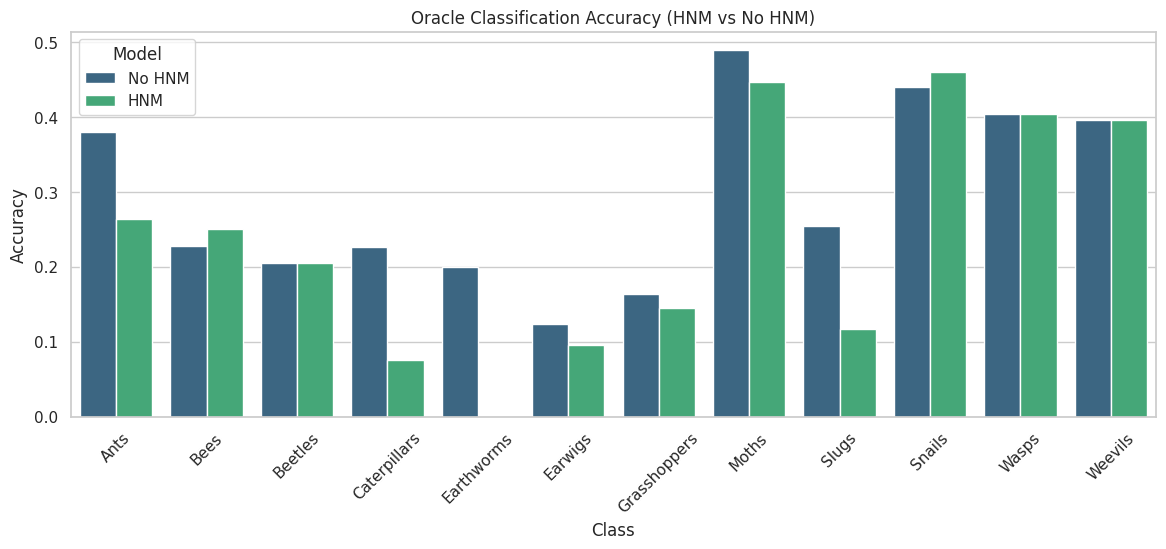

/tmp/ipykernel_55380/2943935922.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, x="Pipeline", y="Accuracy", palette="magma")


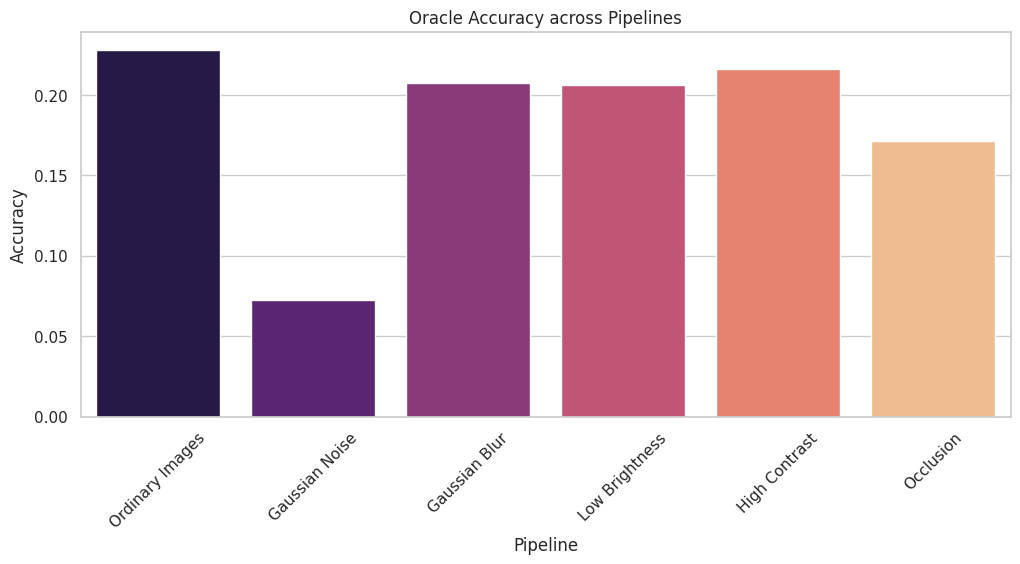

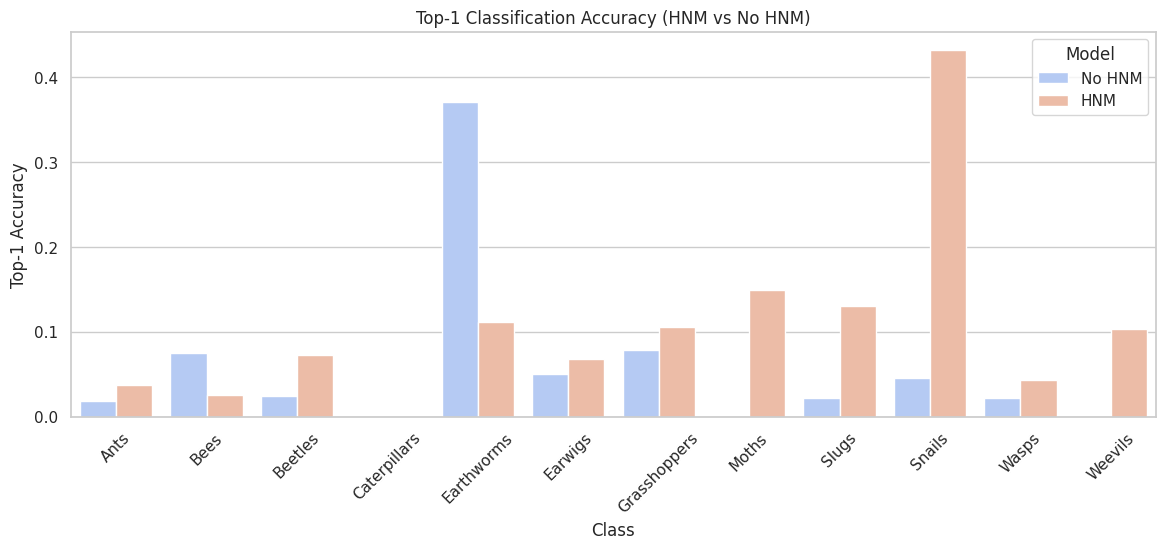

In [15]:
### VISUALISATION

sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

try:
    loaded_results = joblib.load(os.path.join(OUTPUT_DRIVE_PATH, "evaluation_cache.pkl"))
    print("Results loaded from cache.")
except:
    print("Cache not found. Run evaluation first.")
    loaded_results = []

if loaded_results:
    res_std = next((r for r in loaded_results if r["type"] == "No HNM"), None)
    res_hnm = next((r for r in loaded_results if r["pipeline"] == "SVM with HNM - Ordinary Images"), None)

    def get_acc_per_class(raw, key_true, key_pred):
        y_t = raw[key_true]; y_p = raw[key_pred]
        accs = []
        for i in range(len(class_names)):
            idxs = [x for x, val in enumerate(y_t) if val == i]
            if not idxs: accs.append(0.0); continue
            accs.append(sum(1 for x in idxs if y_p[x] == i) / len(idxs))
        return accs

    if res_std and res_hnm:
        df1 = pd.DataFrame({
            "Class": class_names * 2,
            "Accuracy": get_acc_per_class(res_std["raw"], "oracle_true", "oracle_pred") + 
                        get_acc_per_class(res_hnm["raw"], "oracle_true", "oracle_pred"),
            "Model": ["No HNM"]*12 + ["HNM"]*12
        })
        plt.figure(figsize=(14, 5))
        sns.barplot(data=df1, x="Class", y="Accuracy", hue="Model", palette="viridis")
        plt.title("Oracle Classification Accuracy (HNM vs No HNM)"); plt.xticks(rotation=45); plt.show()

        hnm_only = [r for r in loaded_results if r["type"] == "HNM"]
        df2 = pd.DataFrame({"Pipeline": [r["pipeline"].replace("SVM with HNM - ", "") for r in hnm_only], 
                            "Accuracy": [r["Oracle_Accuracy"] for r in hnm_only]})
        plt.figure(figsize=(12, 5))
        sns.barplot(data=df2, x="Pipeline", y="Accuracy", palette="magma")
        plt.title("Oracle Accuracy across Pipelines"); plt.xticks(rotation=45); plt.show()

        df3 = pd.DataFrame({
            "Class": class_names * 2,
            "Top-1 Accuracy": get_acc_per_class(res_std["raw"], "top1_true", "top1_pred") + 
                              get_acc_per_class(res_hnm["raw"], "top1_true", "top1_pred"),
            "Model": ["No HNM"]*12 + ["HNM"]*12
        })
        plt.figure(figsize=(14, 5))
        sns.barplot(data=df3, x="Class", y="Top-1 Accuracy", hue="Model", palette="coolwarm")
        plt.title("Top-1 Classification Accuracy (HNM vs No HNM)"); plt.xticks(rotation=45); plt.show()